Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.1627 - val_loss: 0.0528
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0825 - val_loss: 0.0702
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0673 - val_loss: 0.0537
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0626 - val_loss: 0.0528
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0601 - val_loss: 0.0511
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0628 - val_loss: 0.0545
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0542 - val_loss: 0.0531
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0517 - val_loss: 0.0542
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0504 - val_loss: 0.0581
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0502 - val_loss: 0.0509
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0587 - val_loss: 0.0587
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0537 - val_loss: 0.0539
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Predicted demand for new data: 187.57


<ipython-input-13-f74605e3cb72>:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_sequence[0, -1, 0] = predicted_demand  # 예측 값을 시퀀스의 수요 위치에 반영


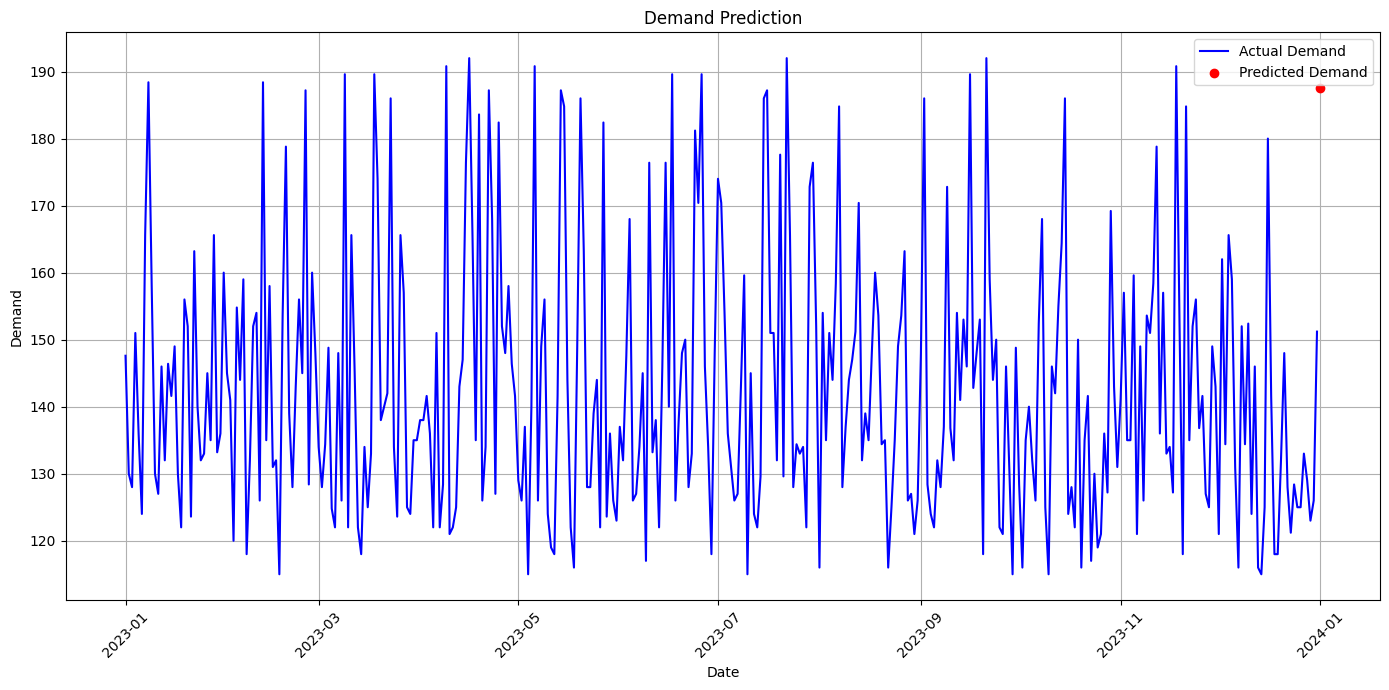

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# CSV 파일에서 데이터 불러오기
df = pd.read_csv('/Modified_Demand_Data2_modified_v2.csv', parse_dates=['Date'])

# Date 컬럼에서 요일과 월을 추출
df['Day_of_Week'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month

# Day_of_Week 원-핫 인코딩
day_encoder = OneHotEncoder(sparse_output=False)
day_of_week_encoded = day_encoder.fit_transform(df[['Day_of_Week']])
day_of_week_df = pd.DataFrame(day_of_week_encoded, columns=day_encoder.get_feature_names_out(['Day_of_Week']))

# 원래 데이터프레임과 병합
df = pd.concat([df, day_of_week_df], axis=1)

# 사용하지 않는 컬럼 제거
data = df.drop(columns=['Date', 'Day_of_Week'])

# MinMaxScaler를 이용하여 스케일링
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 시퀀스 생성 함수 정의
def create_sequences(data, n_steps=7):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, :])
        y.append(data[i+n_steps, 0])
    return np.array(X), np.array(y)

# 시퀀스 생성
n_steps = 14
X, y = create_sequences(scaled_data, n_steps=n_steps)

# 데이터셋을 학습과 테스트 셋으로 분리
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM 모델 생성
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# 새로운 데이터로 예측 수행
new_data = {
    'Demand': [0],  # 예측 대상이므로 0으로 설정
    'Price': [15000],
    'Month': [1],
    'Is_Holiday': [0],
    'Promotion': [0],
    'Temperature': [0],
    'Day_of_Week_Monday': [1],
    'Day_of_Week_Tuesday': [0],
    'Day_of_Week_Wednesday': [0],
    'Day_of_Week_Thursday': [0],
    'Day_of_Week_Friday': [0],
    'Day_of_Week_Saturday': [0],
    'Day_of_Week_Sunday': [0]
}

new_data_df = pd.DataFrame(new_data)
new_data_scaled = scaler.transform(np.vstack([data[-n_steps:], new_data_df]))
new_sequence = new_data_scaled[-n_steps:]

# LSTM 입력 형식으로 변환
new_sequence = new_sequence.reshape((1, n_steps, new_sequence.shape[1]))

# 예측 수행
predicted_demand = model.predict(new_sequence)

# 역변환을 통해 실제 수요로 변환
# 예측 후 역변환 과정
predicted_sequence = np.copy(new_sequence)
predicted_sequence[0, -1, 0] = predicted_demand  # 예측 값을 시퀀스의 수요 위치에 반영
predicted_demand_actual = scaler.inverse_transform(predicted_sequence[0, -1].reshape(1, -1))[0, 0]

print(f"Predicted demand for new data: {predicted_demand_actual:.2f}")

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Demand'], label='Actual Demand', color='blue')

predicted_dates = pd.date_range(start='2024-01-01', periods=1, freq='D')
plt.scatter(predicted_dates, [predicted_demand_actual], color='red', label='Predicted Demand', zorder=5)

plt.title('Demand Prediction')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
